## **FDS project, winter semester 2023**

#### Tommaso Leonardi, Arianna Paolini, Stefano Saravalle, Paolo Cursi, Pietro Signorino
<leonardi.1914546@studenti.uniroma1.it>, <paolini.1943164@studenti.uniroma1.it>, <saravalle.1948684@studenti.uniroma1.it>, <paoloc1999@gmail.com>, <signorino.2149741@studenti.uniroma1.it>

# **Student Performance Analysis & Prediction**

In [535]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

### **Data Preprocessing**

In [536]:
#loading the dataset tables
courses = pd.read_csv('./data/courses.csv')  #22 rows for courses (modules) and their presentations
assess = pd.read_csv('./data/assessments.csv')  #206 rows of assessments for module-presentations (including the final exam)
results = pd.read_csv('./data/studentAssessment.csv') #173,912 rows for the scores obtained by students in the asssesments
studs = pd.read_csv('./data/studentInfo.csv') #32,593 rows for demographic information on students and their results in module-presentations
registr = pd.read_csv('./data/studentRegistration.csv') #32,593 rows for student registration/unregistration on module-presentations
vle = pd.read_csv('./data/studentVle.csv') #10,655,280 rows for daily student interactions with online resources for a module-presentation
materials = pd.read_csv('./data/vle.csv') #6,364 rows for the materials available on the Virtual Learning Environment

The _Open University Learning Analytics dataset_ that we are considering has the following structure: 

 <img src="https://analyse.kmi.open.ac.uk/resources/images/model.png" alt="dataset structure" style="height: 500px; width:500px;"/>


(https://analyse.kmi.open.ac.uk/open_dataset)



In [537]:
#DONE: definire i task -> regressione/classificazione dello score per ogni assessment
#DONE: trasformare valori categorici in numeri
#DONE: normalizzare i dati
#TODO: pulire i dati
#TODO: mostrare la distribuzione dei dati con grafici
#TODO: fare split tra training e test set (considerare cross validation)


Since our goal is to predict the score of each student in any assessment belonging to a specific module presentation, we consider the demographic information about students (from the table *studentInfo*) and their accessess to online resources in the Virtual Learning Environment (VLE) for each course (from the tables *studentVle* and *vle*) as features for our models. 

We also take in account the assessment type and weigth (from the table *assessments*) and the time the student spent before submitting it (from the table *studentAssessment*). 

The target value to predict is the score from the *studentAssessment* table, which ranges from 0 to 100.

In [538]:
#dropping some features
studs = studs.drop("final_result", axis=1)
registr = registr.drop("date_unregistration", axis=1)
materials = materials.drop(["week_from", "week_to"], axis=1)
vle = vle.drop("date", axis=1)
results = results.drop("is_banked", axis=1)

#remove Nan values in studs 'imd_band' (amounts to around 7000 total assessment results)
studs=studs.dropna()

#remove students with 'date registration' that is null (amounts to 7 total assessment results)
registr=registr.dropna()

#match info about a student and his date of registration to a module presentation
studs = studs.merge(registr, how="inner", on=["code_module", "code_presentation","id_student"])

#match a student's interactions with an online resource with the type of the resource
vle = vle.merge(materials, how="inner", on=["code_module", "code_presentation","id_site"] )
vle = vle.drop("id_site", axis=1)

#group the interactions by resource type and add a feature to consider the total sum of clicks for each resource type
temp = vle.groupby(["code_module", "code_presentation", "id_student", "activity_type"]).sum().reset_index()
for x in temp["activity_type"].unique():
    temp[x+"_clicks"] = np.where(temp["activity_type"]==x, temp["sum_click"], 0)
temp = temp.drop(["activity_type","sum_click"], axis=1)
temp = temp.groupby(["code_module", "code_presentation", "id_student"]).sum().reset_index()

#match student's information with his interactions on the VLE for a specific module presentation and fill nan with 0
studs = studs.merge(temp, how="left", on=["code_module", "code_presentation", "id_student"])
studs= studs.fillna(0)

#remove assessments without 'date'=nan and results with 'score'=nan
assess=assess.dropna()
results=results.dropna()
#a=results.merge(assess[assess['date'].isnull()], how="inner", on=["id_assessment"]) #only 2865 instances are removed

#match assessments with students scores
assess = assess.merge(results, how="inner", on="id_assessment")

#substitute date in assessment and date_submitted in results with their difference (to be considered as a time delay from expected submission)
assess["submission_delay"] = assess["date_submitted"] - assess["date"] #"date" is the deadline for the assessment
assess = assess.drop(["date","date_submitted"], axis=1)

#match students with their results
df = studs.merge(assess, how="inner", on=["code_module", "code_presentation","id_student"])

#remove ids from the features
df = df.drop(["code_module","code_presentation","id_student","id_assessment"], axis=1) #163387 total rows
print(df.shape)

(163387, 33)


Some of the features in the dataset have *string* values (eg. 'gender' has values {'M', 'F'}). 

We convert those features to integer values. The list *to_be_converted* contains the names of such features.

In [539]:
df["highest_education"] = df["highest_education"].replace({"No Formal quals":0, "Lower Than A Level":1, "A Level or Equivalent": 2, 
                                                           "HE Qualification":3, "Post Graduate Qualification":4 })

df["imd_band"] = df["imd_band"].replace({"0-10%":0, "10-20":1, "20-30%": 2, "30-40%":3, "40-50%":4, "50-60%":5,
                                          "60-70%":6, "70-80%":7, "80-90%":8, "90-100%":9 })

df["age_band"] = df["age_band"].replace({"0-35":0, "35-55":1, "55<=": 2})

to_be_converted = ["gender", "region", "disability", "assessment_type"]

for column_name in to_be_converted:

    values = set(df[column_name].tolist())
    print(f"Values in '{column_name}' column: {values}")

    mapping = {x : y for y,x in enumerate(values)}
    print(f"Mapping from string values to numerical using the following dictionary: {mapping}")

    df[column_name] = df[column_name].map(mapping)

    print("\n==================================================\n")


Values in 'gender' column: {'F', 'M'}
Mapping from string values to numerical using the following dictionary: {'F': 0, 'M': 1}


Values in 'region' column: {'North Western Region', 'Wales', 'South East Region', 'East Midlands Region', 'Yorkshire Region', 'Ireland', 'South West Region', 'East Anglian Region', 'London Region', 'Scotland', 'South Region', 'North Region', 'West Midlands Region'}
Mapping from string values to numerical using the following dictionary: {'North Western Region': 0, 'Wales': 1, 'South East Region': 2, 'East Midlands Region': 3, 'Yorkshire Region': 4, 'Ireland': 5, 'South West Region': 6, 'East Anglian Region': 7, 'London Region': 8, 'Scotland': 9, 'South Region': 10, 'North Region': 11, 'West Midlands Region': 12}


Values in 'disability' column: {'Y', 'N'}
Mapping from string values to numerical using the following dictionary: {'Y': 0, 'N': 1}


Values in 'assessment_type' column: {'TMA', 'Exam', 'CMA'}
Mapping from string values to numerical using the followin

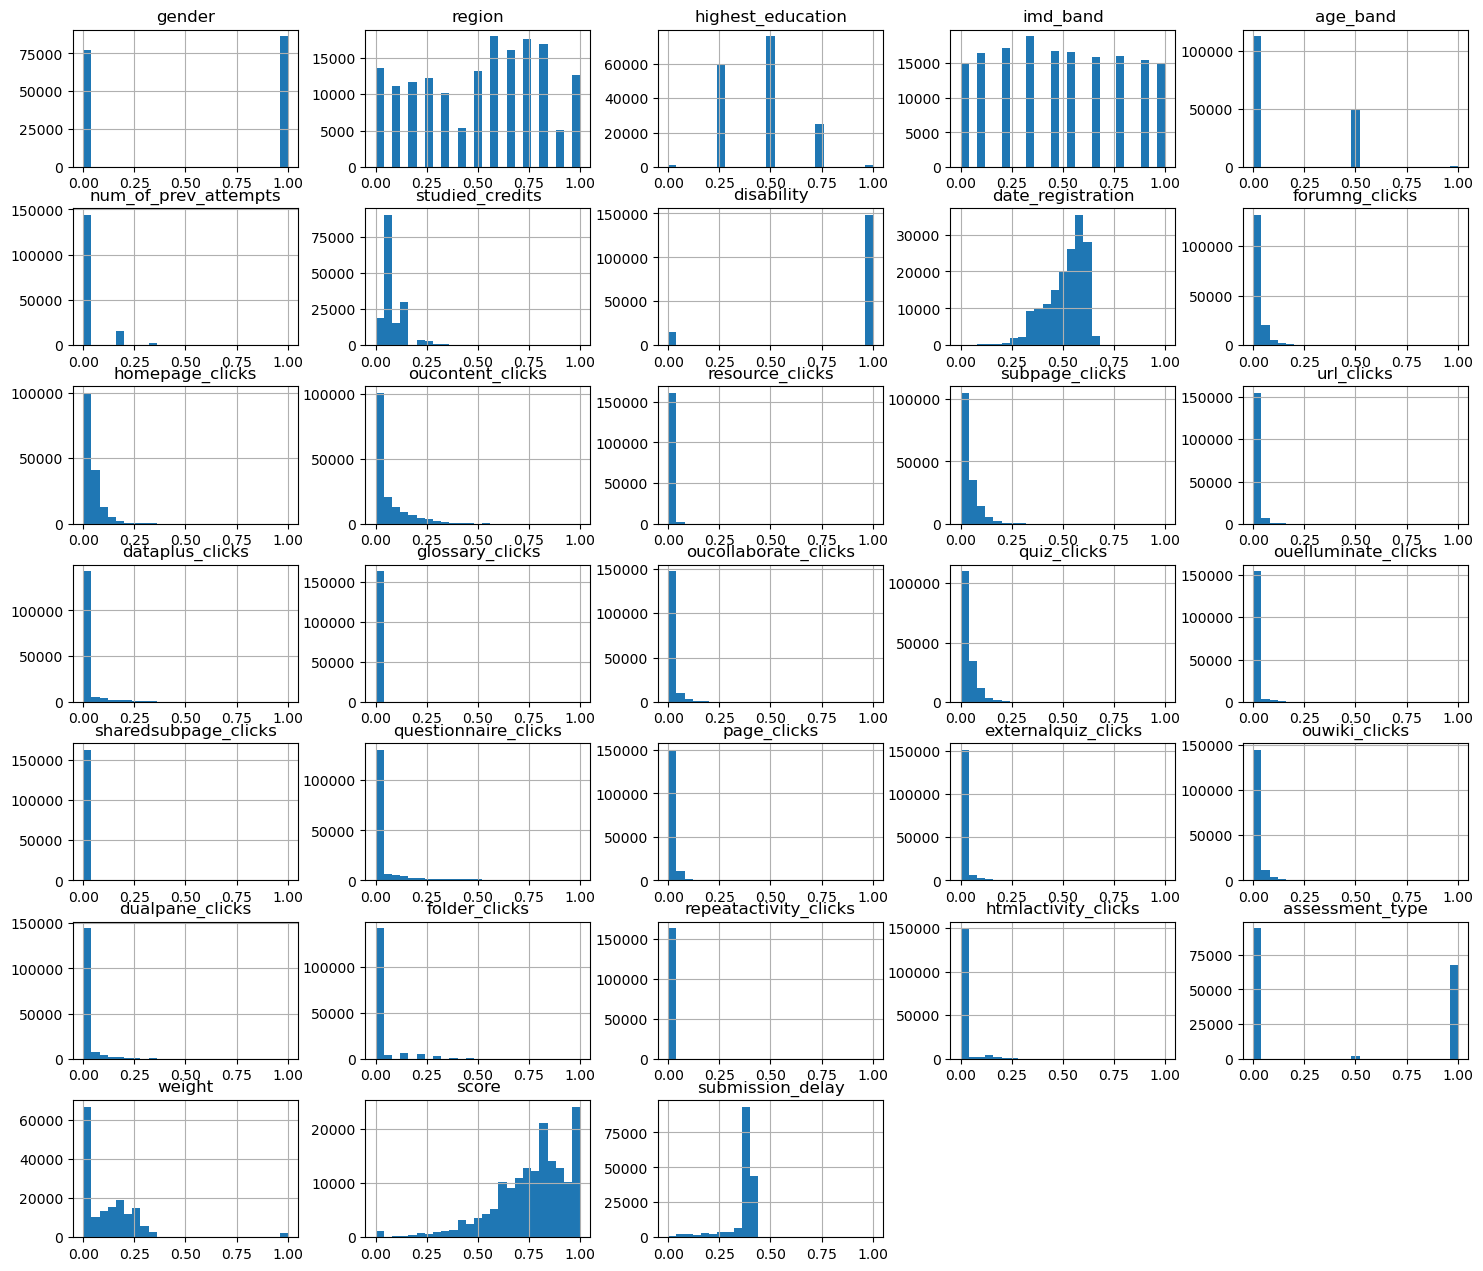

In [548]:
df.hist(layout=(8,5),figsize=(18, 18), bins=25)
plt.show()

After the previous step we now have a dataset containing only *integer values*.

We normalize every feature $f$ with values $vals$ and
- maximum value:  $max$
- minimum value:  $min$

with the following algorithm.

For each $v \in vals$:
$$
v := \frac{v - min}{max - min}
$$

This step ensures that every value in the dataset is in the range $[0,1]$.

In [549]:
for col in df:

    col_max = df[col].max()
    col_min = df[col].min()

    print(f"Normalizing column '{col}' with values between {col_min} and {col_max}")
    print("\n==================================================\n")

    df[col] = (df[col] - col_min) / (col_max - col_min)

Normalizing column 'gender' with values between 0.0 and 1.0


Normalizing column 'region' with values between 0.0 and 1.0


Normalizing column 'highest_education' with values between 0.0 and 1.0


Normalizing column 'imd_band' with values between 0.0 and 1.0


Normalizing column 'age_band' with values between 0.0 and 1.0


Normalizing column 'num_of_prev_attempts' with values between 0.0 and 1.0


Normalizing column 'studied_credits' with values between 0.0 and 1.0


Normalizing column 'disability' with values between 0.0 and 1.0


Normalizing column 'date_registration' with values between 0.0 and 1.0


Normalizing column 'forumng_clicks' with values between 0.0 and 1.0


Normalizing column 'homepage_clicks' with values between 0.0 and 1.0


Normalizing column 'oucontent_clicks' with values between 0.0 and 1.0


Normalizing column 'resource_clicks' with values between 0.0 and 1.0


Normalizing column 'subpage_clicks' with values between 0.0 and 1.0


Normalizing column 'url_clicks' wit

In [550]:
df

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,forumng_clicks,...,externalquiz_clicks,ouwiki_clicks,dualpane_clicks,folder_clicks,repeatactivity_clicks,htmlactivity_clicks,assessment_type,weight,score,submission_delay
0,1.0,0.583333,0.75,1.000000,1.0,0.0,0.35,1.0,0.317992,0.014672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.78,0.396440
1,1.0,0.583333,0.75,1.000000,1.0,0.0,0.35,1.0,0.317992,0.014672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.85,0.396440
2,1.0,0.583333,0.75,1.000000,1.0,0.0,0.35,1.0,0.317992,0.014672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.80,0.394822
3,1.0,0.583333,0.75,1.000000,1.0,0.0,0.35,1.0,0.317992,0.014672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.85,0.394822
4,1.0,0.583333,0.75,1.000000,1.0,0.0,0.35,1.0,0.317992,0.014672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.82,0.393204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163382,0.0,0.333333,0.75,0.555556,0.5,0.0,0.00,1.0,0.592050,0.008438,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00,0.305825
163383,0.0,0.333333,0.75,0.555556,0.5,0.0,0.00,1.0,0.592050,0.008438,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00,0.360841
163384,0.0,0.333333,0.75,0.555556,0.5,0.0,0.00,1.0,0.592050,0.008438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.80,0.359223
163385,0.0,0.333333,0.75,0.555556,0.5,0.0,0.00,1.0,0.592050,0.008438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.80,0.381877
